# Colab Configuration

Mount the drive and change the directory to reach the dataset directory.

In [ ]:
from google.colab import drive

!pip install progressbar2
drive.mount('/content/drive', force_remount=True)
%cd "drive/MyDrive/data_analytics_project/dataset"

Mounted at /content/drive
/content/drive/MyDrive/data_analytics_project/dataset


# Dataset



## Merging
Check for all the existing dataset, and merge them together in order to create an unique dataset foreach category.

In [ ]:
import os
import pandas as pd

categories = {'microphone_mute' : None, 'music_stream': None, 'no_wake_word': None, 'normal_conversation': None}
to_concat = []

for category in categories:
  dir_list = os.listdir(category) # retrieve all files of current category
  datasets = []
  for dataset_name in dir_list: # foreach csv file
    current_dataset = pd.read_csv(category + "/" + dataset_name) # parse csv
    datasets.append(current_dataset) # append this csv to the other
  categories[category] = pd.concat(datasets, ignore_index=True)
  to_concat.append(categories[category])


full_dataset = pd.concat(to_concat, ignore_index=True) # merge all the dataset

## Avoid NaN values
As seen in the previous subsection, there are some values set to NaN, that have no meaning for the classificator. Let's see in detail how many values we have.

In [10]:
print("Features and n° of NaN values")
print(full_dataset.isna().sum())

Features and n° of NaN values
date                 0
length               0
dstip                0
dstport              0
highest_layer        0
delta                0
ack_flag             0
microphone           0
content_type     51563
synchronized         0
class                0
dtype: int64


So, we need to put all the NaN values seen in *content_type* features to a double valid value. Since in this particular feature we have value in range [21.0 - 23.0] we can easily set all the NaN values to 0.0. Then, re-print the NaN values to check if everything is ok. 

In [11]:
import math

new_values = []
for value in full_dataset['content_type']:
  if (math.isnan(value)):
    new_values.append(0.0)
  else:
    new_values.append(value)
full_dataset.update({'content_type': new_values})
print(full_dataset.isna().sum())

date             0
length           0
dstip            0
dstport          0
highest_layer    0
delta            0
ack_flag         0
microphone       0
content_type     0
synchronized     0
class            0
dtype: int64


## Not relevant features
Since we have collected also information related to the particular instance of packets, which cannot be generalized for all the packets it's important to remove those features. In particular, we will remove *date* and *dstip* feature; then print the features.

In [12]:
reduced_dataset = full_dataset.drop('date', 1)
reduced_dataset = reduced_dataset.drop('dstip', 1)

reduced_dataset

,length,dstport,highest_layer,delta,ack_flag,microphone,content_type,synchronized,class
0,77,4070,2.0,0,1,0,0.0,1,syn
1,66,4070,1.0,0,1,0,0.0,1,ack
2,100,443,0.0,0,1,0,23.0,1,syn
3,66,4070,1.0,13318,1,0,0.0,1,ack
4,351,443,0.0,15316,1,0,23.0,1,not_justified
...,...,...,...,...,...,...,...,...,...
62625,66,443,1.0,63,1,1,0.0,1,ack
62626,66,443,1.0,150,1,1,0.0,1,ack
62627,602,443,0.0,2,1,1,23.0,1,expected
62628,97,443,0.0,208,1,1,21.0,1,handshake


## Analysis


### Target class
Start the analysis from understand the distribution of target classes.

48252
4813
2888
1751
1457
1361
1316
792


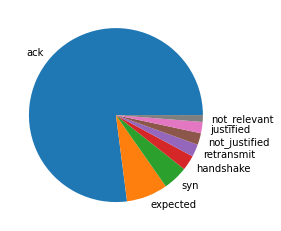

In [13]:
import matplotlib.pyplot as plt
import numpy as np

labels = []
y = []
classes = reduced_dataset['class'].value_counts()
for label, num_items in classes.items():
  labels.append(label)
  print(num_items)
  y.append(num_items)

plt.pie(y, labels = labels)
plt.show() 

Since there are too many packets classified as ack we need to do some kind of reduction; for this reason we will exclude 95% of ack packets.

In [ ]:
reduced_dataset = reduced_dataset.drop(reduced_dataset[reduced_dataset['class'] == 'ack'].sample(frac=0.95).index)

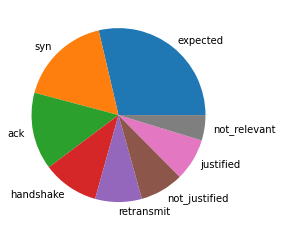

In [ ]:
labels = []
y = []
classes = reduced_dataset['class'].value_counts()
for label, num_items in classes.items():
  labels.append(label)
  y.append(num_items)

plt.pie(y, labels = labels)
plt.show() 

### Features
Let's start our analysis on the features by starting from analyzing the distribution of the lenght of the packets

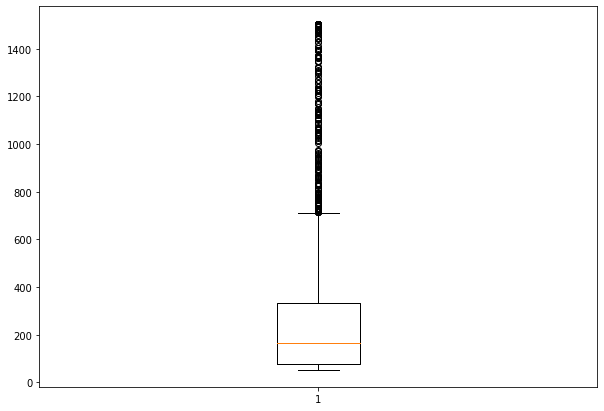

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
  
data = [reduced_dataset['length']]
fig = plt.figure(figsize =(10, 7))

# Creating plot 
plt.boxplot(data) 
  
# show plot 
plt.show() 

Seems that packets have a lot of different values; we know that length till 66 / 100 are synchronization packets, while the higher are communication packets; for this reason we will analyze the length in correlation with the class of the packet

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


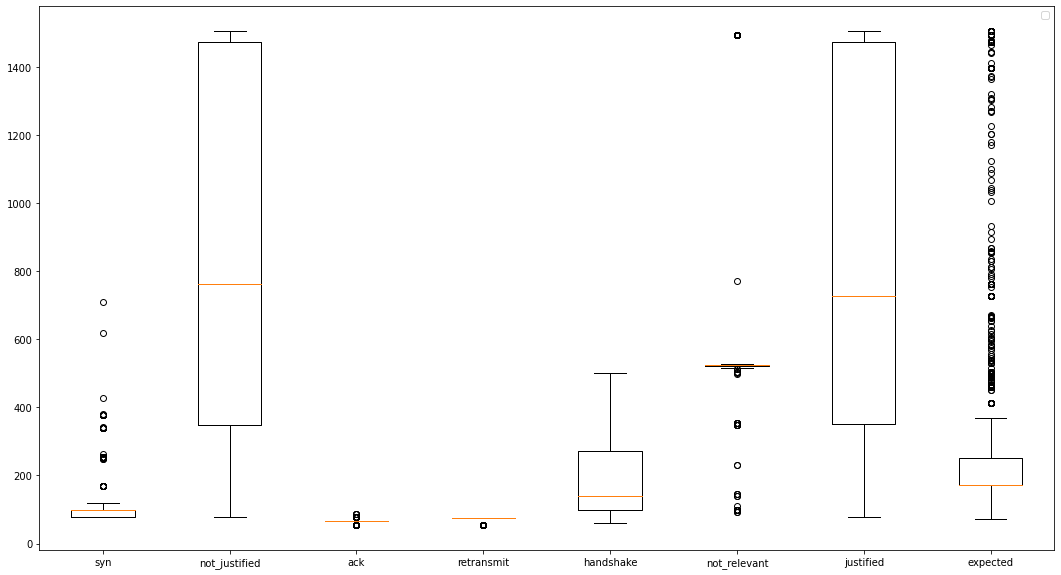

In [ ]:
output_class = reduced_dataset['class'].unique()
fig = plt.figure(figsize=[40,10])
ax1 = fig.add_subplot(1,2,1) # add first subplob
values = []
for target in output_class:
  values.append(reduced_dataset[reduced_dataset['class'] == target]['length'].values)

ax1.boxplot(values, labels=output_class)
ax1.legend()
fig.show() 

So, the justified and the not justified have a different behaviour respect to the expected one, but we can differ the not_justified from the justified by the microphone features, as we can see below.

Not justified packets with microphone on:  886
Justified packets with microphone on:  1316

Not justified packets with microphone off:  475
Justified packets with microphone off:  0


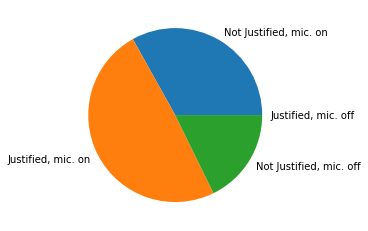

In [14]:
y = []
labels = []
print("Not justified packets with microphone on: ",str(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 1) & (reduced_dataset['class'] == 'not_justified')].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 1) & (reduced_dataset['class'] == 'not_justified')].index))
labels.append("Not Justified, mic. on")
print("Justified packets with microphone on: ",str(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 1) & (reduced_dataset['class'] == 'justified')].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 1) & (reduced_dataset['class'] == 'justified')].index))
labels.append("Justified, mic. on")
print()
print("Not justified packets with microphone off: ",str(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 0) & (reduced_dataset['class'] == 'not_justified')].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 0) & (reduced_dataset['class'] == 'not_justified')].index))
labels.append("Not Justified, mic. off")
print("Justified packets with microphone off: ",str(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 0) & (reduced_dataset['class'] == 'justified')].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['microphone'] == 0) & (reduced_dataset['class'] == 'justified')].index))
labels.append("Justified, mic. off")

plt.pie(y, labels = labels)
plt.show() 


In fact, there is no justified packet when the microphone has been disabled.
Let's analyze the synchronization and ack flag features.

Synchronized:  16791
Not Synchronized:  0


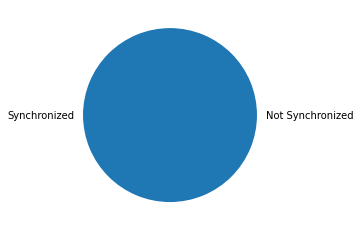

In [ ]:
y = []
labels = []
print("Synchronized: ",str(len(reduced_dataset.loc[(reduced_dataset['synchronized'] == 1)].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['synchronized'] == 1)].index))
labels.append("Synchronized")
print("Not Synchronized: ",str(len(reduced_dataset.loc[(reduced_dataset['synchronized'] == 0)].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['synchronized'] == 0)].index))
labels.append("Not Synchronized")

plt.pie(y, labels = labels)
plt.show() 

Ack flag:  15334
No ack flag:  1457


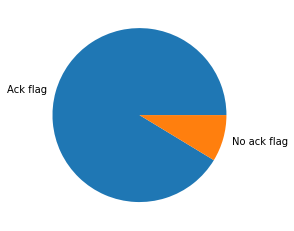

In [ ]:
y = []
labels = []
print("Ack flag: ",str(len(reduced_dataset.loc[(reduced_dataset['ack_flag'] == 1)].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['ack_flag'] == 1)].index))
labels.append("Ack flag")
print("No ack flag: ",str(len(reduced_dataset.loc[(reduced_dataset['ack_flag'] == 0)].index)))
y.append(len(reduced_dataset.loc[(reduced_dataset['ack_flag'] == 0)].index))
labels.append("No ack flag")

plt.pie(y, labels = labels)
plt.show() 

As show in the last pie chart there is any packet captured during the no-synchronization phase; this behaviour is justified by the fact that is impossible to capture packet when the device is not sychronized. The just initialized Echo will ask to the user to configure the Echo using Amazon Alexa app, that is associated with an account, so it must be always synchronized with an account to work. For these reasons we will remove the synchronization feature.

Regarding the ack flag instead, since a lot of communication packets (justified / not justified) contains an ack together with the application data we need to store this feature.

In [ ]:
reduced_dataset = reduced_dataset.drop('synchronized', 1)

Let's compute the distribution of highest layer, remembering the meaning of each value:
* 0 - SSL
* 1 - TCP
* 2 - DATA
* 3 - HTTP


0.0 : 11067
1.0 : 4418
2.0 : 725
3.0 : 581


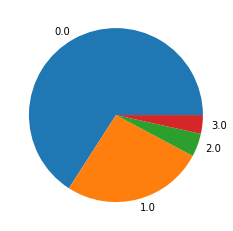

In [ ]:
labels = []
y = []
classes = reduced_dataset['highest_layer'].value_counts()
for label, num_items in classes.items():
  print(label,  ":", num_items)
  labels.append(label)
  y.append(num_items)

plt.pie(y, labels = labels)
plt.show() 

## Store
After applied the dataset normalization / merging techniques; we can proceed to save the obrained dataset.

In [ ]:
reduced_dataset.to_csv('final_dataset.csv', index=False)
reduced_dataset

,length,dstport,highest_layer,delta,ack_flag,microphone,content_type,class
0,77,4070,2.0,0,1,0,0.0,syn
2,100,443,0.0,0,1,0,23.0,syn
4,351,443,0.0,15316,1,0,23.0,not_justified
6,77,4070,2.0,0,1,0,0.0,syn
9,100,443,0.0,0,1,0,23.0,syn
...,...,...,...,...,...,...,...,...
62622,164,443,0.0,0,1,1,23.0,expected
62623,626,443,0.0,0,1,1,23.0,expected
62624,104,443,0.0,0,1,1,23.0,expected
62627,602,443,0.0,2,1,1,23.0,expected


# Machine Learning

## Load and split
Loading of the dataset and split it into train and test dataset by removing the last column that contains the target values. The split follow the 80/20 technique.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
final_dataset = pd.read_csv('final_dataset.csv')
X = final_dataset.iloc[:, 0:7].values
y = final_dataset.iloc[:, 7].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

## Normalization
Let's make the data more regular by applying a min-max transformation.

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6
0,-0.566642,-0.238161,0.743862,0.352757,0.306141,0.465356,-1.386874
1,-0.500205,-0.238161,-0.616829,-0.307203,0.306141,-2.148891,0.740828
2,-0.623236,-0.238161,0.743862,-0.307203,0.306141,0.465356,-1.386874
3,-0.409162,-0.238161,-0.616829,-0.303590,0.306141,0.465356,0.648319
4,-0.409162,-0.238161,-0.616829,-0.304816,0.306141,0.465356,0.648319
...,...,...,...,...,...,...,...
13427,-0.574024,4.379061,0.743862,-0.241723,-3.266474,-2.148891,-1.386874
13428,-0.332883,-0.238161,-0.616829,-0.304558,0.306141,0.465356,0.740828
13429,-0.510047,-0.238161,-0.616829,1.628423,0.306141,-2.148891,0.740828
13430,2.873308,-0.238161,-0.616829,-0.307139,0.306141,-2.148891,0.740828


## Features evaluation

No handles with labels found to put in legend.


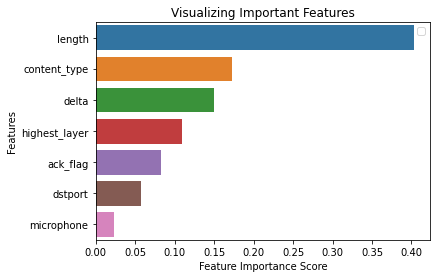

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X_train_scaled, Y_train)

# Predict the test set
y_pred=clf.predict(X_test_scaled)

feature_imp = pd.Series(clf.feature_importances_,index=["length", "dstport", "highest_layer", "delta", "ack_flag", "microphone", "content_type"]).sort_values(ascending=False)

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()